In [1]:
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
from IPython import display

import time
import random

from chirpotle.context import tpy_from_context

# tx-test

This example shows how you can use Jupyter Notebooks to interact with ChirpOTLE.

The result will be a test of the channel between two ChirpOTLE nodes measuring frame loss.

## Get Access To Devices

Like in script files, you can use the `tpy_from_context()` from the `chirpotle.context` module to access the nodes. The available nodes are defined by the configuration that you've selected when running `chirpotle.sh notebook`:

```bash
chirpotle.sh notebook --conf <name-of-config>
```

In [2]:
tc, devices = tpy_from_context()

You are running TPyControl in version 0.0.0
Connected to 2 remote nodes

node    host               proxy                                 modules (name[:type])
------  -----------------  ------------------------------------  -----------------------
alice   loranode1.example  PYRO:tpynode@loranode1.example:42337  lora:LoRa
bob     loranode2.example  PYRO:tpynode@loranode2.example:42337  lora:LoRa


After running the command, you should see a list of the connected nodes.

**Troubleshooting (1)**: If you see a message like `Could not connect to ...`, the tpynode application is probably not running on the server.\
Run `chirpotle.sh deploy` and then `chirpotle.sh restartnodes` to (re)start the application on all nodes. The `deploy` step will also flash the firmware on all configured and connected MCUs. If you used a `--conf` argument for running the notebook, make sure to append the same `--conf` argument to the `deploy` and `restartnodes` step.

**Troubleshooting (2)**: If you only see an empty list, you may need to configure your setup first.\
Stop the notebook, then run `chirpotle.sh confeditor`. For a beginner, the easiest would be to modify the `default` configuration and to add at least 2 nodes (or one node with 2 devices connected to it).

In the list, you see the name of the node in the first column and the name of one or more `LoRa` interfaces in the last column. These are the names you've configured in the configuration editor. You can use the names to access your devices.

Let's assume we have the following output:

```
node    host           proxy                             modules (name[:type])
------  -------------  --------------------------------  -----------------------
alice   alice.example  PYRO:tpynode@alice.example:42337  lora:LoRa
```

You can then use `tc.nodes['alice']['lora']` to access the `LoRa` interface.

For convenience, we assign two nodes to the variables `alice` and `bob`. You may need to adjust this to your setup. The script completely relies on those variables, so this is the only place you'll need to change.

In [3]:
alice = tc.nodes['alice']['lora']
bob   = tc.nodes['bob']['lora']

## Configuring the Channel

We start simple by putting both devices into standby mode. In standby mode, the receiver, transmitter, and jammer of the devices are deactivated. It is a good idea to set all your devices explicitly into standby mode at the beginning of an experiment to be sure that you don't unintentionally interfere with your measurements.

Setting them to standby is as simple as calling `standby()` on the `LoRa` nodes:

In [4]:
alice.standby()
bob.standby()

0

Now, we check the radio configuration of node alice. Therefore, we call `get_lora_channel()` on the node. this function will return a dictionary with a number of properties which are explained below:

In [5]:
print(alice.get_lora_channel())

{'frequency': 869524963, 'bandwidth': 250, 'spreadingfactor': 7, 'syncword': 18, 'codingrate': 5, 'invertiqtx': True, 'invertiqrx': False, 'explicitheader': True}


The properties have the following function/meaning:

| Property          | Unit | Range       | Description |
| ----------------- | ---- | ----------- | ----------- |
| `frequency`       | Hz   | 860M - 880M | Transmission center frequency |
| `bandwidth`       | kHz  | 125,250,500 | Bandwidth of the LoRa signal |
| `spreadingfactor` |      | 7-12        | Spreading factor of the LoRa signal |
| `syncword`        |      | 0-255       | Syncword. Usually `0x12` for private and `0x34` for public LoRaWAN networks |
| `codingrate`      |      | 5-8         | FEC settings (for rx only in implicit header mode). 5 means 5/8, 6 means 6/8... |
| `invertiqtx`      |      | true/false  | Whether the polarity should be inverted during transmission (see below) |
| `invertiqrx`      |      | true/false  | Whether the polarity should be inverted during receiving (see below) |
| `explicitheader`  |      | true/false  | If explicit header mode should be used (LoRaWAN: true for all except beacons) |

The polarity depends on the message type. In general, the following relation exists between `invertiqtx` and `invertiqrx`:

|                        | `invertiqtx=True`  | `invertiqtx=False` |
| ---------------------- | ------------------ | ------------------ |
| **`invertiqrx=True`**  | doesn't work       | works              |
| **`invertiqrx=False`** | works              | doesn't work       |

For LoRaWAN, use the following settings for different message types:

| Message Type | `invertiqrx` on receiver | `invertiqtx` on transmitter |
| ------------ | ------------------------ | --------------------------- |
| Uplink       | `True`                   | `True`                      |
| Downlink     | `False`                  | `False`                     |
| Beacon       | `True`                   | `True`                      |

For this example, we use the following channel definition:

In [6]:
channel = {
    'frequency': 868100000,
    'bandwidth': 125,
    'spreadingfactor': 7,
    'syncword': 18,
    'codingrate': 5,
    'invertiqtx': True,
    'invertiqrx': False,
    'explicitheader': True,
}

The counterpart of `get_lora_channel()` is `set_lora_channel()`. This function takes keyword arguments with the same names that are used in the dictionary returned by `get_lora_channel()`. If an argument is not provided, the corresponding property remaines unchanged. So, `alice.set_lora_channel(frequency=868300000)` would only change the frequency.

We can use the unpack operator to pass our `channel` variable to the function:

In [7]:
alice.set_lora_channel(**channel)

{'frequency': 868099975,
 'bandwidth': 125,
 'spreadingfactor': 7,
 'syncword': 18,
 'codingrate': 5,
 'invertiqtx': True,
 'invertiqrx': False,
 'explicitheader': True}

> **Note:** Calling `set_lora_channel()`, even without parameters, implicitly calls `standby()` on that specific node.

As the parameter names are the same, we also can easily copy the channel configuration from one node to another:

In [8]:
bob.set_lora_channel(**alice.get_lora_channel())

{'frequency': 868099914,
 'bandwidth': 125,
 'spreadingfactor': 7,
 'syncword': 18,
 'codingrate': 5,
 'invertiqtx': True,
 'invertiqrx': False,
 'explicitheader': True}

> **Caution:** Keep an eye on the values of `invertiqtx` and `invertiqrx` when doing this. If they are the same, this means that both nodes cannot talk to each other.

## The First Message

Now, it is time to let the nodes talk to each other.

First, we put the node that should receive frames into receive mode by calling `receive()`:

In [9]:
bob.receive()

0

Now, bob listens to incoming messages on the previously configured channel and stores them. As storing is done on the MCU, you should regularly fetch incoming frames from there.

To transmit one frame, we use the `transmit_frame()` function on the other node. The first parameter is required and has to be a sequence of numbers in the range of 0..255, representing one byte each. You can send arbitrary data and are not bound to valid LoRaWAN messages:

In [10]:
payload = [ord(c) for c in 'ChirpOTLE']

print("Payload is:", payload)

alice.transmit_frame(payload, blocking=True)

Payload is: [67, 104, 105, 114, 112, 79, 84, 76, 69]


0

We use the optional `blocking` parameter and set it to `True` so that the call will return only after the transmission is complete (this is helpful if you re-evaluate the whole notebook).

Now, we can query bob for received frames:

In [11]:
recv_frame = bob.fetch_frame()

print(recv_frame)

{'has_more': False, 'frames_dropped': False, 'rssi': -72, 'snr': -23, 'time_valid_header': 63030406445, 'time_rxdone': 63030421734, 'crc_error': False, 'payload': [67, 104, 105, 114, 112, 79, 84, 76, 69]}


If the transmission was successful and a frame was received, you will get its payload together with some meta data:

| Field               | Description |
| ------------------- | ----------- |
| `has_more`          | If a repeated call to `fetch_frame()` will return another frame |
| `frames_dropped`    | If the MCU ran out of space and frames have been dropped since the last call to `fetch_frame()` |
| `rssi`              | RSSI of the frame, dBm
| `snr`               | SNR of the frame, dB
| `time_valid_header` | Time when the LoRa receiver fired the _valid header interrupt_. This happens either after the LoRa-internal PHY header has been demodulated and decoded (explicit header mode) or after the 2.25 reverse chirps of the preamble have been received (implicit header mode). Times are relative values in microseconds and based on the MCU internal clock. |
| `time_rxdone`       | Time when the complete frame has been received and demodulated, also relative time value in microseconds based on the MCU clock. |
| `crc_error`         | If the modem detected a CRC error on the physical layer |
| `payload`           | The payload, same format as for the first parameter of `transmit_frame()` |

So we now can compare the `payload` field of the fetched frame with the value we sent:

In [12]:
if recv_frame is None:
    print("Frame was lost")
else:
    if recv_frame['payload']==payload:
        print("Frame received:", "".join([chr(b) for b in recv_frame['payload']]))
    else:
        print("Frame corrupted.")

Frame received: ChirpOTLE


Before we continue, we put both nodes into standby again:

In [13]:
alice.standby()
bob.standby()

0

## Running a Test

We now write the first automated test to generate _quantitative_ results. We want to evaluate the link quality between two of our framework's nodes. We do it in three steps: We define meta data (node configuration), test parameters (which we may want to adjust to compare different scenarios), and the test itself.

We start by defining the metadata: In this case, the different data rates that we want to evaluate (using those for the EU868 region):

In [14]:
# LoRaWAN data rates according to EU868 regional specification
datarates = {
    "DR0": {"spreadingfactor": 12, "bandwidth": 125},
    "DR1": {"spreadingfactor": 11, "bandwidth": 125},
    "DR2": {"spreadingfactor": 10, "bandwidth": 125},
    "DR3": {"spreadingfactor":  9, "bandwidth": 125},
    "DR4": {"spreadingfactor":  8, "bandwidth": 125},
    "DR5": {"spreadingfactor":  7, "bandwidth": 125},
    "DR6": {"spreadingfactor":  7, "bandwidth": 250},
}

# Use the data rates to get lables for the plot
dr_labels = sorted(datarates.keys())

Now, we configure the parameters for the experiments.

The **number of rounds** decides how many packets are sent for each data rate.

The **frame length** configures the length of the LoRa frame. LoRaWAN creates an overhead of around 12 bytes per frame, plus MAC commands and payload.

The **frequency** is the frequency to transmit on (like already specified in the channel definition above). Note that each frequency comes with its specific duty cycle.

The **duty cycle** for the frequency as percentage. For a 10% duty cycle, use a value of `0.1`.

In [15]:
# Parameter: Number of round for the experiment
num_rounds = 20

# Parameter: Frame length
frame_len = 12

# Frequency to use
frequency = 869525000

# Duty Cycle on that frequency
duty_cycle = 0.10

We use the definitions from above and the parameters to create an experiment in which alice sends random frames to bob, and we check if bob receives them correctly. This scenario is a good template to, for example, evaluate the performance of a jammer.

We create three lists to collect the results and then define a result chart using matplotlib. In the main loop, we iterate thorugh the runs of the experiment and, per run, over the data rates. When we have the outcome for a run, we add it to the result lists. In `update_chart()`, these values are forwareded to the matplotlib figure, which is then updated.

<IPython.core.display.Javascript object>


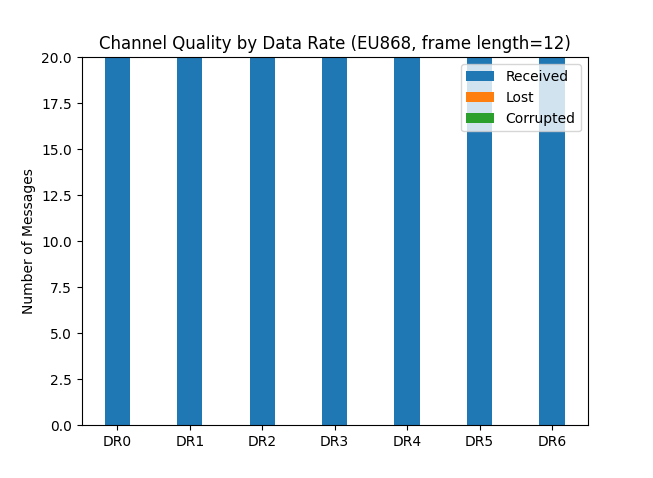

In [16]:
# Received message count (per data rate)
count_recv = [0 for _ in dr_labels]

# Lost message count (per data rate)
count_lost = [0 for _ in dr_labels]

# Corrupted message count (per data rate)
count_corrupt = [0 for _ in dr_labels]

# matplotlib plot
fig, ax = plt.subplots()

# Stack the bars for each data rate
bar_width = 0.35
bar_recv = ax.bar(dr_labels, count_recv, bar_width, label='Received')
bar_lost = ax.bar(dr_labels, count_lost, bar_width, bottom=count_recv, label='Lost')
bar_corrupt = ax.bar(dr_labels, count_corrupt, bar_width, bottom=count_lost, label='Corrupted')

# Legends and labels
ax.set_ylim([0,num_rounds])
ax.set_ylabel('Number of Messages')
ax.set_title('Channel Quality by Data Rate (EU868, frame length=%d)' % frame_len)
ax.legend()

# Function to update the data after each frame
def update_chart():
    for n in range(len(dr_labels)):
        bar_recv[n].set_height(count_recv[n])
        bar_lost[n].set_height(count_lost[n])
        bar_lost[n].set_y(count_recv[n])
        bar_corrupt[n].set_height(count_corrupt[n])
        bar_corrupt[n].set_y(count_recv[n]+count_lost[n])
    fig.canvas.flush_events()
    fig.canvas.draw()

plt.show()
for n in range(num_rounds):
    for drname,dridx in zip(dr_labels,range(len(dr_labels))):        
        # Create channel for this run and set it (this will also sent devices to standby)
        channel_run = {**channel,**datarates[drname],"frequency":frequency}
        alice.set_lora_channel(**channel_run)
        bob.set_lora_channel(**channel_run)
        
        # Make bob the receiver
        bob.receive()
        
        # Create random frame data
        frm = [random.randrange(0, 256) for _ in range(frame_len)]
        
        # Send and capture time
        txstart = time.time()
        alice.transmit_frame(frm, blocking=True)
        txend = time.time()
        
        # Wait a short moment so that the receiver is done
        time.sleep(0.2)
        
        # Check if the receiver got the same frame
        frm_state="lost"
        frm_rx = bob.fetch_frame()
        while frm_rx is not None and frm_state!="received":
            if frm_rx['payload']==frm:
                frm_state="received"
            elif len(frm_rx['payload'])==frame_len:
                frm_state="corrupted"
            frm_rx = bob.fetch_frame()
        bob.standby()
        
        # Update the data
        if frm_state=="received":
            count_recv[dridx]+=1
        elif frm_state=="corrupted":
            count_corrupt[dridx]+=1
        else:
            count_lost[dridx]+=1
        
        # Update the chart to show real-time results
        update_chart()
        
        # Wait the remaining time of the duty cycle
        frm_duration=txend-txstart
        time.sleep(frm_duration/duty_cycle-frm_duration)